In [1]:
# ライブラリをインポート

# データ操作と数値計算のため
import pandas as pd
import numpy as np

# データ可視化のため
import matplotlib.pyplot as plt
import seaborn as sns

# 統計モデリングと計量経済分析のため
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from scipy import stats

# for ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = "https://www.fbc.keio.ac.jp/~tyabu/keiryo/growth_data.csv"
_df = pd.read_csv(url)

date_range = pd.date_range(
  start = '1981-03-01',
  end = '2007-12-31',
  freq = 'Q' # 四半期
)
_df['date'] = date_range # date列に上書き

_df['d_1991'] = (_df['date'] > '1991-03-31').astype(int) # 1991年第1四半期以前は0，さもなくば1．
_df['d_1991_growth'] = _df['d_1991'] * _df['growth'].shift() # d_1991列が1をとる時，前期のgrowthをとる．
_df['growth_lag'] = _df['growth'].shift() # 前期のgrowth
df = _df.dropna()
df.head()

,date,growth,d_1991,d_1991_growth,growth_lag
1,1981-06-30,6.149155,0,0.0,4.320439
2,1981-09-30,4.221881,0,0.0,6.149155
3,1981-12-31,2.468659,0,0.0,4.221881
4,1982-03-31,3.497315,0,0.0,2.468659
5,1982-06-30,3.035303,0,0.0,3.497315


# 作図

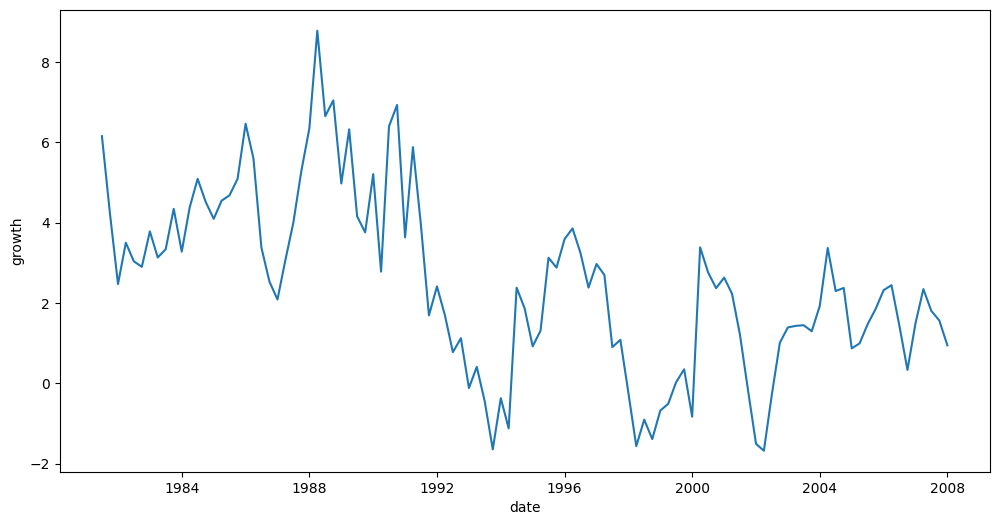

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(
    df['date'],
    df['growth']
)
plt.xlabel('date')
plt.ylabel('growth')
plt.show()

# 7.4.1節の推定結果

In [3]:
endog = df['growth']
exog = df['growth_lag']
exog = sm.add_constant(exog)

model_1 = sm.OLS(endog, exog)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     234.5
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           1.62e-28
Time:                        21:32:11   Log-Likelihood:                -172.92
No. Observations:                 107   AIC:                             349.8
Df Residuals:                     105   BIC:                             355.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3965      0.181      2.187      0.0

In [5]:
endog = df['growth']
exog = df[['growth_lag', 'd_1991', 'd_1991_growth']]
exog = sm.add_constant(exog)

model_2 = sm.OLS(endog, exog)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     96.64
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           7.98e-30
Time:                        21:18:37   Log-Likelihood:                -164.08
No. Observations:                 107   AIC:                             336.2
Df Residuals:                     103   BIC:                             346.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2968      0.583      3.943

# 7.4.2節の推定結果

In [6]:
endog = df['growth']
exog = df['growth_lag']
exog = sm.add_constant(exog)

model_1 = sm.OLS(endog, exog)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     234.5
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           1.62e-28
Time:                        21:18:38   Log-Likelihood:                -172.92
No. Observations:                 107   AIC:                             349.8
Df Residuals:                     105   BIC:                             355.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3965      0.181      2.187      0.0

In [4]:
# 構造変化の検出関数
def sup_f_test(endog, exog, breakpoint):
    n = len(endog)
    k = exog.shape[1]

    exog1 = exog[:breakpoint]
    exog2 = exog[breakpoint:]
    endog1 = endog[:breakpoint]
    endog2 = endog[breakpoint:]

    model = sm.OLS(endog, exog).fit()
    model1 = sm.OLS(endog1, exog1).fit()
    model2 = sm.OLS(endog2, exog2).fit()

    rss = model.ssr
    rss1 = model1.ssr
    rss2 = model2.ssr

    f_stat = ((rss - (rss1 + rss2)) / k) / ((rss1 + rss2) / (n - 2 * k))
    p_value = 1 - stats.f.cdf(f_stat, k, n - 2*k)

    return f_stat, p_value

Estimated break point date: 1991-03-31 00:00:00
supF statistic: 9.2546
Minimum p-value: 0.0002


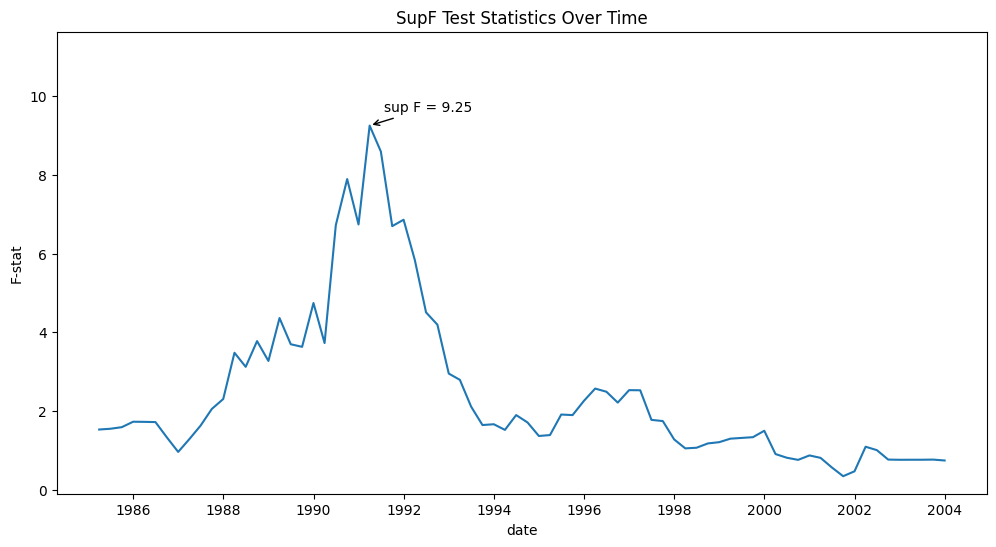

In [5]:
# すべての可能な分割点でsupF検定を実行
f_statistics = []
p_values = []
T = len(df)
T_B_min = round(T * 0.15)
T_B_max = round(T * (1-0.15))
endog = df['growth']
exog = df['growth_lag']
exog = sm.add_constant(exog)

for i in range(T_B_min, T_B_max+1):  # データの両端15%をトリミング
    f_stat, p_val = sup_f_test(endog, exog, i)
    f_statistics.append(f_stat)
    p_values.append(p_val)

# f_statisticsをデータフレームに追加
df['f_stat'] = pd.Series(f_statistics, index=range(T_B_min, T_B_max+1))

# 最大のF統計量を持つ点を構造変化点として特定
breakpoint = np.argmax(f_statistics) + T_B_min
breakpoint_date = df.iloc[breakpoint-1]['date']
max_f_stat = np.max(f_statistics)
min_p_value = np.min(p_values)

print(f"Estimated break point date: {breakpoint_date}")
print(f"supF statistic: {max_f_stat:.4f}")
print(f"Minimum p-value: {min_p_value:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(
    df['date'],
    df['f_stat']
)
plt.xlabel('date')
plt.ylabel('F-stat')
plt.title('SupF Test Statistics Over Time')
current_ymin, current_ymax = plt.ylim()
plt.ylim(current_ymin, current_ymax * 1.2)
plt.annotate(
        f'sup F = {max_f_stat:.2f}',
        xy = (breakpoint_date, max_f_stat),
        xytext = (10, 10),
        textcoords = 'offset points',
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0')
)
plt.show()
